# Partial Least Squares Model of Differentiation Signatures using Expression of Transcription Factor Genes

Natacha Comandante-Lou

Nov, 2021

_Data source:_

Tsoi, J., Robert, L., Paraiso, K., Galvan, C., Sheu, K. M., Lay, J., Wong, D., Atefi, M., Shirazi, R., Wang, X., Braas, D., Grasso, C. S., Palaskas, N., Ribas, A., & Graeber, T. G. (2018). Multi-stage Differentiation Defines Melanoma Subtypes with Differential Vulnerability to Drug-Induced Iron-Dependent Oxidative Stress. Cancer cell, 33(5), 890–904.e5. https://doi.org/10.1016/j.ccell.2018.03.017

## 1. Read data

In [1]:
import pandas as pd
import numpy as np

log2fpkm = pd.read_csv('Tsoi_log2_GSE80829_FPKM.csv').rename({'Gene':'cell_line_id'},axis = 1).set_index('cell_line_id').T
log2fpkm['cell_line'] = log2fpkm.index.str.replace('_DMSO','')
log2fpkm.reset_index(drop=True,inplace=True)

metadata = pd.read_csv('Tsoi_GSE80829_metadata.csv')

#Create a single dataframe
df = pd.merge(metadata,log2fpkm,on="cell_line")
df.cell_type = pd.Series(df["cell_type"], dtype="category").cat.reorder_categories(['Melanocytic','Transitory','Neural crest like','Undifferentiated'])

del log2fpkm, metadata

* #### List of TF genes


In [2]:
tf_names = pd.read_csv('hs_hgnc_tfs.txt',delimiter = "\n",header=None)
tf_names.columns = ['Gene']
print("Number of TFs: ",len(tf_names))
all_genes = pd.DataFrame({"Gene":df.columns[9:]})
tf_names = tf_names[tf_names['Gene'].isin(all_genes["Gene"])]
print(len(tf_names),"TFs are in the gene list")

Number of TFs:  1839
1817 TFs are in the gene list


* #### List of differentiation signature genes from Tsoi et al.


In [3]:
sig_genes = pd.read_csv('sig_genes.csv')
sig_names = sig_genes['Gene']
sig_names

0         AJUBA
1         TOR4A
2        MARCH4
3        ZDHHC2
4        ZNF467
         ...   
526       ABCB5
527      APOLD1
528    ANKRD30B
529       ADCY2
530      ADAM23
Name: Gene, Length: 531, dtype: object

* #### Selected AP-1s based on VIP scores (|VIP|>1)

In [8]:
selected_ap1s = ["FOS","FOSL1","FOSL2","JUN","JUNB","JUND","ATF2","ATF4"]

* #### Create list for TF set minus AP-1 set and signature gene set

In [9]:
tf_no_ap1_names = list(set(list(tf_names['Gene']))-set(ap1_names))
tf_no_ap1_no_sig_names = list(set(tf_no_ap1_names)-set(sig_names.to_list()))
print("Using", len(tf_no_ap1_no_sig_names),"TFs, which are not in the signature gene list")

Using 1756 TFs, which are not in the signature gene list


## 2. Set up PLSR pipeline

In [10]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt

* #### PLSR function

In [11]:
def run_plsr(df,selected_factors,seed_id,n_splits,val_size):
 
    print('selected factors: ', selected_factors)
    df_selected = df[np.concatenate([metadata_columns,selected_factors])]

    X = df_selected.drop(metadata_columns,axis = 1,inplace=False)
    Y = df_selected[metadata_columns[2:]]
    # Create Pipeline
    pipe = Pipeline([('Scale', StandardScaler()),
                 ('PLS', PLSRegression(max_iter=1000))])
    # Create CV folds
    ymat = np.tile(np.transpose(df_selected.cell_type.cat.codes.to_numpy()), (Y.shape[1],1)).T
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=val_size, random_state=seed_id)
    
    # Optimal Parameter Search
    param_grid = {'PLS__n_components': np.arange(len(selected_factors))+1,}
    search = GridSearchCV(pipe, param_grid, cv=sss.split(X,ymat)).fit(X, Y)

    # Cross Validation Results
    scoring = ['r2','explained_variance','neg_mean_squared_error']
    cv_results = cross_validate(search.best_estimator_, X, Y, cv=sss.split(X,ymat),scoring = scoring,return_train_score=True)
    
    ## output mean cv_results
    cv_results_stats = dict()
    cv_results_stats['train_r2_mean'] = cv_results['train_r2'].mean()
    cv_results_stats['test_r2_mean'] = cv_results['test_r2'].mean()
    cv_results_stats['train_explained_variance_mean'] = cv_results['train_explained_variance'].mean()
    cv_results_stats['test_explained_variance_mean'] = cv_results['test_explained_variance'].mean()
    cv_results_stats['train_neg_mean_squared_error_mean'] = cv_results['train_neg_mean_squared_error'].mean()
    cv_results_stats['test_neg_mean_squared_error_mean'] = cv_results['test_neg_mean_squared_error'].mean()
    
    cv_results_stats['train_r2_std'] = cv_results['train_r2'].std()
    cv_results_stats['test_r2_std'] = cv_results['test_r2'].std()
    cv_results_stats['train_explained_variance_std'] = cv_results['train_explained_variance'].std()
    cv_results_stats['test_explained_variance_std'] = cv_results['test_explained_variance'].std()
    cv_results_stats['train_neg_mean_squared_error_std'] = cv_results['train_neg_mean_squared_error'].std()
    cv_results_stats['test_neg_mean_squared_error_std'] = cv_results['test_neg_mean_squared_error'].std()
    

    return cv_results_stats


In [12]:
#input-----
n_iter =500000 #number of iterations
seed_id = 235 #for sss
n_splits = 20 #number of splitting iterations in cross validation (CV)
val_size = 0.1 #test data/validation set size


## 3. Iterate pipeline for randomly selected sets of TF (excluding AP-1 and signature genes)

* #### Function for generating random combinations 

In [13]:
import random
import itertools
def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)


* #### Iterate using multiple pools (Main)

In [14]:
# n choose r
n = len(tf_no_ap1_no_sig_names)
r = len(selected_ap1s)

metadata_columns = ['cell_line','cell_type','M_score','MT_score','T_score','TN_score','N_score','NU_score','U_score']


In [ ]:
from multiprocessing.pool import Pool
from multiprocessing import current_process, Process
#import multiprocessing
from time import time
import random


random.seed(seed_id) #for random combination


# iter function
def myf(_):

    created = Process()
    current = current_process()
    print('running:', current.name, current._identity)
    print('created:', created.name, created._identity)
    selected_factors = np.array(tf_no_ap1_no_sig_names)[np.asarray(random_combination(range(n), r))]
    
    results= run_plsr(df,selected_factors,seed_id,n_splits,val_size)
    return [results, selected_factors]

pool = Pool(30)
tic_fwd = time()
results, selected_factors = zip(*pool.map(myf, range(n_iter)))
toc_fwd = time()
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
#pool.close()



In [16]:
#Save Results
df_results = pd.DataFrame.from_dict(results)
df_results['selected_factors'] = selected_factors

df_results.to_csv(f'seed{seed_id}_cv_{val_size}_nsplit{n_splits}_iter{n_iter}_results.csv')

## 4. AP-1 PLSR

In [17]:
results_ap1= run_plsr(df,selected_ap1s,seed_id,n_splits,val_size)

#Save Results
df_results_ap1 = pd.DataFrame(results_ap1,index=[0])
df_results_ap1['selected_factors'] = [selected_ap1s]
df_results_ap1.to_csv(f'seed{seed_id}_cv_{val_size}_nsplit{n_splits}_iter{n_iter}_AP-1_results.csv')

selected factors:  ['FOS', 'FOSL1', 'FOSL2', 'JUN', 'JUNB', 'JUND', 'ATF2', 'ATF4']


Empirical P-value: 0.011444


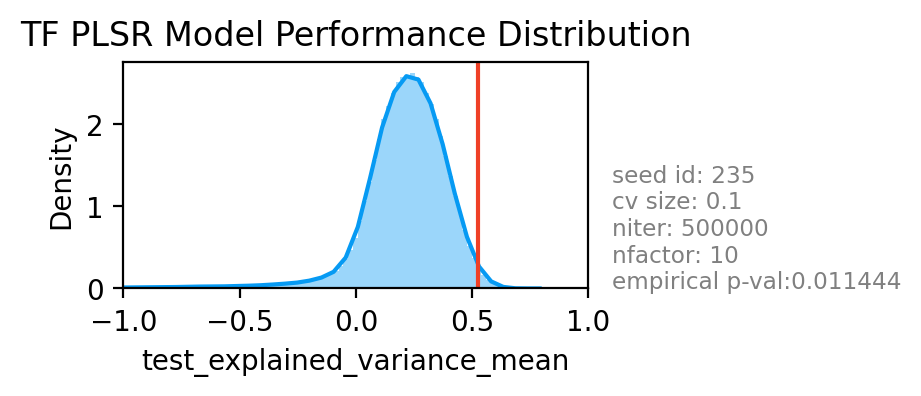

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
#Input-----------------
n_iter =500000
seed_id = 235 #for sss
n_splits = 20
val_size = 0.1
r = 8
#Read------------------
df_results = pd.read_csv(f'seed{seed_id}_cv_{val_size}_nsplit{n_splits}_iter{n_iter}_results.csv')
df_results_ap1 = pd.read_csv(f'seed{seed_id}_cv_{val_size}_nsplit{n_splits}_iter{n_iter}_AP-1_results.csv')

metrics = 'test_explained_variance_mean'
c = (df_results[metrics]>df_results_ap1[metrics][0]).sum()
emp_pval = c/n_iter #calculate empirical p-value
print('Empirical P-value:',emp_pval)

#Plot------------------
%matplotlib inline
warnings.filterwarnings("ignore")
fig, ax = plt.subplots(figsize=(3,1.5),dpi = 200)

sns.distplot(df_results[metrics].to_numpy(),color='xkcd:azure',bins=500)
plt.text(1.1,0, f'seed id: {seed_id}\ncv size: {val_size}\nniter: {n_iter}\nnfactor: {r}\nempirical p-val:{emp_pval}', 
         horizontalalignment='left', size='small', color='gray')
plt.axvline(x=df_results_ap1[metrics].to_numpy(),c='xkcd:tomato')
plt.xlabel(metrics)
plt.xlim(-1,1)
plt.title("TF PLSR Model Performance Distribution")
plt.savefig(f'TF_PLSR_Model_{metrics}_Distribution.pdf', format='pdf')
